# Ссылки на метриалы

В основном использовал это:

https://github.com/bioinf-jku/SNNs

Из других просто брал теорию и пару моментов

https://arxiv.org/pdf/1905.01338.pdf

https://arxiv.org/pdf/1706.02515.pdf

https://www.hardikp.com/2017/07/24/SELU-vs-RELU/

https://towardsdatascience.com/selu-make-fnns-great-again-snn-8d61526802a9

https://github.com/tonyduan/snn

https://github.com/zxqfd555/machine-learning-braindump/blob/master/README.md#a1-6



# Импорт библиотек, подключение диска, объявление функций, классов и параметров

In [ ]:
# Подключение гугл диска для сохранения туда датасетов для избежания их повторного скачивания
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import cuda
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.modules import loss

from torchvision.datasets import CIFAR10, MNIST
from torchvision import transforms

import numpy as np

from tqdm import tqdm

from matplotlib import pyplot as plt

import time

In [ ]:
# Аппаратура, на которой производятся вычисления
# cpu - обычный процессор, cuda - графический процессор (значительно быстрее)
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Директория для скачивания датасетов
ROOT = '/content/drive/MyDrive/datasets'

# Символ переноса строки (чисто для практических целей)
LB = '\n'

# Символ табуляции (чисто для практических целей)
TAB = '\t'

In [ ]:
# Класс-обертка для класса обычного DataLoader
# Отличием является то, что датасет разбивается на батчи заранее
# Чтобы не повторять этот процесс в каждой эпохе, 
# так как он занимает ~20-25 секунд
class FastDataloader:

    def __init__(self, dataloader: DataLoader[Dataset], force: bool = False):
        self.dataloader = dataloader
        self._force = force
        self._bathes = [0] * len(self.dataloader)
        self._create_batches()

    @property
    def dataset(self):
        return self.dataloader.dataset

    def __len__(self):
        return len(self.dataloader)

    def __iter__(self):
        if self._force:
            self._create_batches()
        return self._get_iterator()

    def _create_batches(self):
        for i, batch in enumerate(self.dataloader):
            self._bathes[i] = batch

    def _get_iterator(self):
        for batch in self._bathes:
            yield batch

# Функция для скачивания и создания DataLoader-ов
def prepare_data(
    dataset_class: Dataset, # Сам датасет (так как все используемые датасеты
    # брались из предоставляемых самим pytorch, они предствляют из себя не таблицы, а отдельные классы)
    transform: transforms.Compose # Объект преобразований датасетов (обычно ToTensor и Normalize)
) -> dict[str, DataLoader]:

  # Тренировочный датасет
  train_data = dataset_class(
    root=ROOT,
    train=True,
    download=True,
    transform=transform
  )

  # Обучающий датасет
  test_data = dataset_class(
      root=ROOT,
      train=False,
      download=True,
      transform=transform
  )

  # Вывод информации о датасете
  print(f'\nКоличество строк в обучающей выборке: {len(train_data)}')
  print(f'Количество строк в тестовой выборке: {len(test_data)}\n')
  print(f'Классы:\n{LB.join([f"{i + 1}.{TAB}{classname}" for i, classname in enumerate(train_data.classes)])}')

  # Dataloader для тренировочного датасета
  train_dataloader = FastDataloader(DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
  ))

  # Dataloader для обучающего датасета
  test_dataloader = FastDataloader(DataLoader(
      test_data,
      batch_size=BATCH_SIZE
  ))

  return {'train': train_dataloader, 'test': test_dataloader}

In [ ]:
# Функция для обучения сети в рамках одной эпохи 
def train_iteration(
    net: nn.Module, # Сеть
    dataloader: DataLoader, # DataLoader для тренировочного датасета
    optimizer: optim.Optimizer, # Оптимизатор 
    loss: loss._Loss, # Функция ошибки
    batches_number: int,  # Количество батчей в DataLoader
    data: dict[str, list] # Словарь для сохранения информации об метриках по эпохам
) -> None:
  # Переключение сети в режим обучения
  net.train()
  # Счетчик для средней ошибки по батчам
  total_loss_value = 0
  for X, y in dataloader:
    # Перевод тензоров на нужный процессор (графический/обычный)
    X, y = X.to(DEVICE), y.to(DEVICE)
    # Обнуление переменных оптимизатора
    optimizer.zero_grad()
    # Прогон данных по сети для получения предсказанных значений
    pred = net(X)
    # Подсчет значения функции ошибки
    loss_value = loss(pred, y)
    # Обратное распростронение ошибки
    loss_value.backward()
    # Шаг в стороны локального минимума на градиентной плоскости
    optimizer.step()
    # Учет значения ошибки на текущем батче
    total_loss_value += loss_value.item()
  # Сохранение среднего значения ошибки по батчам на данной эпохе
  data['loss'].append(total_loss_value / batches_number)
  # Сохранение значения accuracy на данной эпохе
  data['train_accuracy'].append(accuracy_score(net, dataloader))

# Функция для теста сети в рамках одной эпохи 
def test_iteration(
    net: nn.Module, # Сеть
    dataloader: DataLoader, # DataLoader для тестового датасета
    data: dict[str, list] # Словарь для сохранения информации об метриках по эпохам
) -> None:
  # Переключение сети в режим теста
  net.eval()
  # Сохранение значения accuracy на данной эпохе
  data['test_accuracy'].append(accuracy_score(net, dataloader))

# Функция подсчета accuracy
def accuracy_score(
    net: nn.Module, # Сеть
    dataloader: DataLoader # DataLoader, по которому производится расчет
) -> float:
  # Отключение подсчета градиента
  with torch.no_grad():
    # Общее количество правильно предсказанных значений
    correct_pred = 0
    for X, y in dataloader:
      # Перевод тензоров на нужный процессор (графический/обычный)  
      X, y = X.to(DEVICE), y.to(DEVICE)
      # Прогон данных по сети для получения предсказанных значений
      pred = net(X)
      # Подсчет правильго предсказанных значений
      correct_pred += (pred.argmax(1) == y).type(torch.float).sum().item()
  # Относительная доля правильно предсказанных значений от общего количества значений
  return correct_pred / len(dataloader.dataset)

# Функция для запуска процесса обучения и тестирования сети
def loop(
    net: nn.Module, # Сеть
    dataloaders: dict[str, DataLoader], # Словарь с DataLoader-ами
    optimizer: optim.Optimizer, # Оптимизатор
    loss: loss._Loss, # Функция ошибки
    data: dict[str, list] # Словарь для сохранения информации об метриках по эпохам
) -> None:
  # Количество батчей в DataLoader с обучающим датасетом
  batches_number = len(dataloaders['train'])
  for epoch in range(EPOCHS):
    # Время начала эпохи
    start = time.time()
    # Вызов функции обучение сети
    train_iteration(
        net,
        dataloaders['train'],
        optimizer,
        loss,
        batches_number,
        data
    )
    # Вызов функции тестирования сети
    test_iteration(
        net,
        dataloaders['test'],
        data
    )
    # Вывод длительности эпохи
    print(f'epoch = {epoch + 1}{TAB}time = {time.time() - start:.4f}s')



In [ ]:
# Функция для вывода диаграмм об эффективностях моделей
def diagrams(
    relu_data: dict[str, list], # Словарь с метриками эффективности обычной модели
    selu_data: dict[str, list], # Словарь с метриками эффективности само-нормализующейся модели
) -> None:
  # Общий размер всей фигуры
  plt.figure(figsize=(10, 10))
  # Заголовок всей фигуры
  plt.suptitle('Сравнение эффективностей моделей')

  # Вся нижняя половина фигуры
  plt.subplot(212)
  # График значения ошибки по эпохам обычной модели
  plt.plot(range(EPOCHS), relu_data['loss'], c='r', label='ReLU loss')
  # График значения ошибки по эпохам само-нормализующейся модели
  plt.plot(range(EPOCHS), selu_data['loss'], c='b', label='SELU loss')
  # Заголовок диаграммы
  plt.title('Понижение значения функции ошибки по эпохам')
  # Подпись горизонтальной оси
  plt.xlabel('Эпохи')
  # Подпись вертикальной оси
  plt.ylabel('Значение функции ошибки')
  # Вывод легенды
  plt.legend()

  # Левая верхняя четверть фигуры
  plt.subplot(221)
  # График значения accuracy на обучающей выборке по эпохам обычной модели
  plt.plot(range(EPOCHS), relu_data['train_accuracy'], c='r', label='ReLU accuracy')
  # График значения accuracy на обучающей выборке по эпохам само-нормализующейся модели
  plt.plot(range(EPOCHS), selu_data['train_accuracy'], c='b', label='SELU accuracy')
  # Заголовок диаграммы
  plt.title('Рост accuracy в обучающей выборке по эпохам')
  # Подпись горизонтальной оси
  plt.xlabel('Эпохи')
  # Подпись вертикальной оси
  plt.ylabel('Значение accuracy')
  # Вывод легенды
  plt.legend()

  # Правая верхняя четверть фигуры
  plt.subplot(222)
  # График значения accuracy на обучающей выборке по эпохам обычной модели
  plt.plot(range(EPOCHS), relu_data['test_accuracy'], c='r', label='ReLU accuracy')
  # График значения accuracy на обучающей выборке по эпохам само-нормализующейся модели
  plt.plot(range(EPOCHS), selu_data['test_accuracy'], c='b', label='SELU accuracy')
  # Заголовок диаграммы
  plt.title('Рост accuracy в тестовой выборке по эпохам')
  # Подпись горизонтальной оси
  plt.xlabel('Эпохи')
  # Подпись вертикальной оси
  plt.ylabel('Значение accuracy')
  # Вывод легенды
  plt.legend()

# Сверточная нейронная сеть

## Гиперпараметры

In [ ]:
# Скорость обучения
LR = 0.001
# Количество эпох
EPOCHS = 20
# Размер батча
BATCH_SIZE = 1000
# Вероятность для Dropout-а
DROP_PROBABILITY = 0.1

## Подготовка данных

In [ ]:
# Данные для предобработки датасетов
data_for_preprocessing = CIFAR10(
    root=ROOT,
    train=True,
    download=True,
    transform=transforms.ToTensor()
).data.astype(np.float64)

transform = transforms.Compose([
    transforms.ToTensor(),
    # Нормализация данных датасета
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])


dataloaders = prepare_data(CIFAR10, transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Количество строк в обучающей выборке: 50000
Количество строк в тестовой выборке: 10000

Классы:
1.	airplane
2.	automobile
3.	bird
4.	cat
5.	deer
6.	dog
7.	frog
8.	horse
9.	ship
10.	truck


## Модель

In [ ]:
class CNN(nn.Module):

    def __init__(self, out_features: int, drop_probability: float, self_norm: bool):
        super(CNN, self).__init__()

        # В зависимости от типа сети (обычная/самор-нормализующаяся) выбирается либо либо ReLU и обычный Dropout
        # либо SELU и AlphaDropout
        activation_layer = nn.SELU(True) if self_norm else nn.ReLU(True)
        dropout_layer = nn.AlphaDropout(p=drop_probability) if self_norm else nn.Dropout(p=drop_probability)

        # Сама сеть
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            activation_layer,
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            activation_layer,
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            activation_layer,
            nn.Flatten(),
            nn.Linear(in_features=128*4*4, out_features=2048),
            activation_layer,
            nn.Linear(in_features=2048, out_features=1024),
            activation_layer,
            nn.Linear(in_features=1024, out_features=out_features)
        )

        # Если сеть само-нормализующаяся, то надо переинициализировать веса с другим случайным распределением
        if self_norm:
            for parameter in self.model.parameters():
                # Если это смещение, то оно обнуляется 
                if len(parameter.shape) == 1:
                    nn.init.constant_(parameter, 0)
                # В обратном случае, это веса и их нужно переинициализировать
                else:
                    nn.init.kaiming_normal_(parameter, mode='fan_in', nonlinearity='linear')


    def forward(self, x):
        return self.model(x)

## Обучение

In [ ]:
# Функция ошибки
loss = nn.CrossEntropyLoss
# Оптимизатор
optimizer = optim.Adam

In [ ]:
# Инициализация обычной сети и ее перевод на нужный процессор (обычный/графический)
cnn = CNN(
    out_features=len(dataloaders['train'].dataset.classes),
    drop_probability=DROP_PROBABILITY,
    self_norm=False
).to(DEVICE)

In [ ]:
# Структура сети
print(cnn)

CNN(
  (model): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=2048, out_features=2048, bias=True)
    (10): ReLU(inplace=True)
    (11): Linear(in_features=2048, out_features=1024, bias=True)
    (12): ReLU(inplace=True)
    (13): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [ ]:
# Словарь для метрик по эпохам
relu_data = {'loss': [], 'train_accuracy': [], 'test_accuracy': []}
# Запуск сети
loop(
    cnn,
    dataloaders,
    optimizer(cnn.parameters(), lr=LR),
    loss(),
    relu_data
)

epoch = 1	time = 5.4888s
epoch = 2	time = 5.4815s
epoch = 3	time = 5.4817s
epoch = 4	time = 5.5190s
epoch = 5	time = 5.5248s
epoch = 6	time = 5.5638s
epoch = 7	time = 5.5670s
epoch = 8	time = 5.5558s
epoch = 9	time = 5.5503s
epoch = 10	time = 5.5306s
epoch = 11	time = 5.5311s
epoch = 12	time = 5.5216s
epoch = 13	time = 5.5200s
epoch = 14	time = 5.5043s
epoch = 15	time = 5.4862s
epoch = 16	time = 5.5025s
epoch = 17	time = 5.4961s
epoch = 18	time = 5.5250s
epoch = 19	time = 5.5170s
epoch = 20	time = 5.5225s


In [ ]:
# Инициализация само-нормализующейся сети и ее перевод на нужный процессор (обычный/графический)
cnn = CNN(
    out_features=len(dataloaders['train'].dataset.classes),
    drop_probability=DROP_PROBABILITY,
    self_norm=True
).to(DEVICE)

In [ ]:
# Структура сети
print(cnn)

CNN(
  (model): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): SELU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): SELU(inplace=True)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): SELU(inplace=True)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=2048, out_features=2048, bias=True)
    (10): SELU(inplace=True)
    (11): Linear(in_features=2048, out_features=1024, bias=True)
    (12): SELU(inplace=True)
    (13): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [ ]:
# Словарь для метрик по эпохам
selu_data = {'loss': [], 'train_accuracy': [], 'test_accuracy': []}
# Запуск
loop(
    cnn,
    dataloaders,
    optimizer(cnn.parameters(), lr=LR),
    loss(),
    selu_data
)

epoch = 1	time = 5.7663s
epoch = 2	time = 5.7484s
epoch = 3	time = 5.7809s
epoch = 4	time = 5.7550s
epoch = 5	time = 5.7591s
epoch = 6	time = 5.7498s
epoch = 7	time = 5.7307s
epoch = 8	time = 5.7356s
epoch = 9	time = 5.7208s
epoch = 10	time = 5.7380s
epoch = 11	time = 5.7175s
epoch = 12	time = 5.7269s
epoch = 13	time = 5.7330s
epoch = 14	time = 5.7350s
epoch = 15	time = 5.7492s
epoch = 16	time = 5.7269s
epoch = 17	time = 5.7461s
epoch = 18	time = 5.7407s
epoch = 19	time = 5.7336s
epoch = 20	time = 5.7438s


## Сравнение

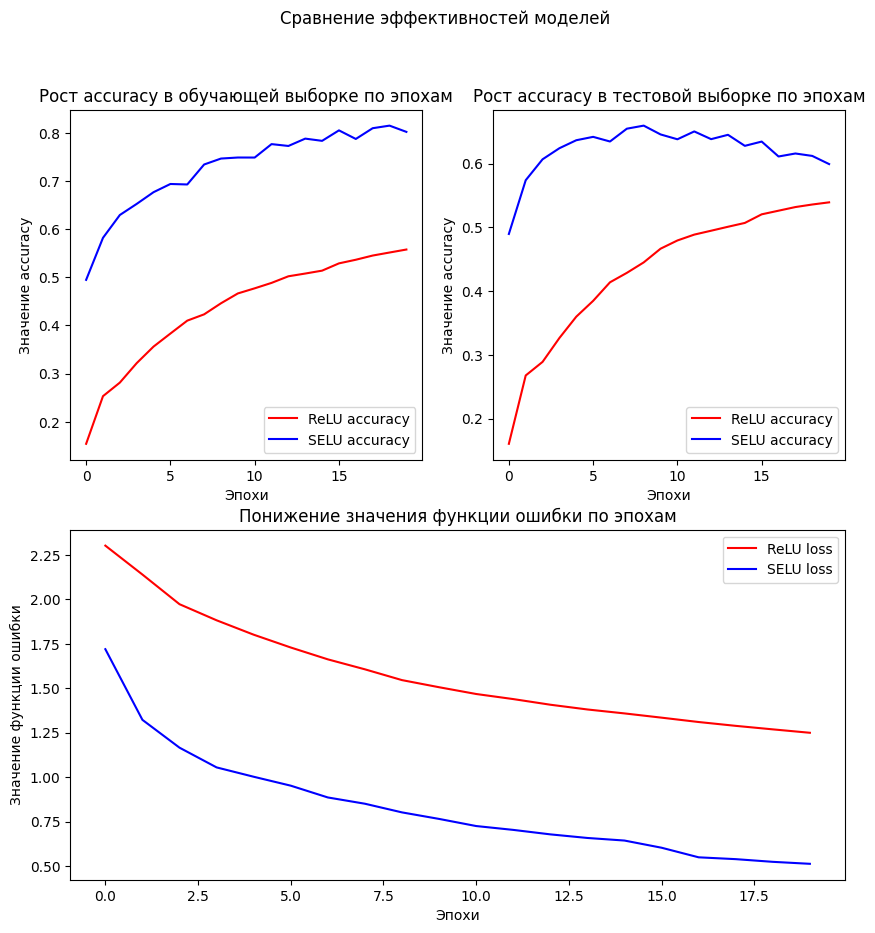

In [ ]:
# Вывод сравнительных диаграмм
diagrams(relu_data, selu_data)

# Многослойный перцептрон

## Гиперпараметры

In [ ]:
# Скорость обучения
LR = 0.001
# Количество эпох
EPOCHS = 50
# Размер батча
BATCH_SIZE = 1000
# Вероятность для Dropout-а
DROP_PROBABILITY = 0.05

## Подготовка данных

In [ ]:
# Данные для предобработки датасетов
data_for_preprocessing = MNIST(
    root=ROOT,
    train=True,
    download=True,
    transform=transforms.ToTensor()
).data.to(torch.float64)

transform = transforms.Compose([
    transforms.ToTensor(),
    # Нормализация данных датасета
    transforms.Normalize(
        data_for_preprocessing.mean() / 255,
        data_for_preprocessing.std() / 255
    )
])

dataloaders = prepare_data(MNIST, transform)

Количество строк в обучающей выборке: 60000
Количество строк в тестовой выборке: 10000

Классы:
1.	0 - zero
2.	1 - one
3.	2 - two
4.	3 - three
5.	4 - four
6.	5 - five
7.	6 - six
8.	7 - seven
9.	8 - eight
10.	9 - nine


## Модель

In [ ]:
class MLP(nn.Module):

    def __init__(self, in_features:int, out_features: int, drop_probability: float, self_norm: bool):
        super(MLP, self).__init__()

        # В зависимости от типа сети (обычная/самор-нормализующаяся) выбирается либо либо ReLU и обычный Dropout
        # либо SELU и AlphaDropout
        activation_layer = nn.SELU(True) if self_norm else nn.ReLU(True)
        dropout_layer = nn.AlphaDropout(p=drop_probability) if self_norm else nn.Dropout(p=drop_probability)

        # Сама сеть
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_features, out_features=512),
            activation_layer,
            dropout_layer,
            nn.Linear(in_features=512, out_features=256),
            activation_layer,
            dropout_layer,
            nn.Linear(in_features=256, out_features=out_features)
        )

        # Если сеть само-нормализующаяся, то надо переинициализировать веса с другим случайным распределением
        if self_norm:
            for parameter in self.model.parameters():
                # Если это смещение, то оно обнуляется 
                if len(parameter.shape) == 1:
                    nn.init.constant_(parameter, 0)
                # В обратном случае, это веса и их нужно переинициализировать
                else:
                    nn.init.kaiming_normal_(parameter, mode='fan_in', nonlinearity='linear')


    def forward(self, x):
        return self.model(x)

## Обучение

In [ ]:
# Функция ошибки
loss = nn.CrossEntropyLoss
# Оптимизатор
optimizer = optim.Adadelta

In [129]:
# Инициализация обычной сети и ее перевод на нужный процессор (обычный/графический)
mlp = MLP(
    in_features=dataloaders['train'].dataset.data.shape[1] * dataloaders['train'].dataset.data.shape[2],
    out_features=len(dataloaders['train'].dataset.classes),
    drop_probability=DROP_PROBABILITY,
    self_norm=False
).to(DEVICE)

In [130]:
# Структура сети
print(mlp)

MLP(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [ ]:
# Словарь для метрик по эпохам
relu_data = {'loss': [], 'train_accuracy': [], 'test_accuracy': []}
# Запуск
loop(
    mlp,
    dataloaders,
    optimizer(mlp.parameters(), lr=LR),
    loss(),
    relu_data
)

epoch = 1	time = 0.3019s
epoch = 2	time = 0.2571s
epoch = 3	time = 0.2440s
epoch = 4	time = 0.2504s
epoch = 5	time = 0.2530s
epoch = 6	time = 0.2569s
epoch = 7	time = 0.2469s
epoch = 8	time = 0.2601s
epoch = 9	time = 0.2439s
epoch = 10	time = 0.2462s
epoch = 11	time = 0.2496s
epoch = 12	time = 0.2455s
epoch = 13	time = 0.2659s
epoch = 14	time = 0.2500s
epoch = 15	time = 0.2516s
epoch = 16	time = 0.3012s
epoch = 17	time = 0.2729s
epoch = 18	time = 0.2882s
epoch = 19	time = 0.2794s
epoch = 20	time = 0.2881s
epoch = 21	time = 0.2767s
epoch = 22	time = 0.2842s
epoch = 23	time = 0.2804s
epoch = 24	time = 0.2800s
epoch = 25	time = 0.2783s
epoch = 26	time = 0.2789s
epoch = 27	time = 0.2878s
epoch = 28	time = 0.2914s
epoch = 29	time = 0.2958s
epoch = 30	time = 0.2456s
epoch = 31	time = 0.2378s
epoch = 32	time = 0.2497s
epoch = 33	time = 0.2418s
epoch = 34	time = 0.2538s
epoch = 35	time = 0.2521s
epoch = 36	time = 0.2395s
epoch = 37	time = 0.2467s
epoch = 38	time = 0.2501s
epoch = 39	time = 0.2

In [131]:
# Инициализация само-нормализующейся сети и ее перевод на нужный процессор (обычный/графический)
mlp = MLP(
    in_features=dataloaders['train'].dataset.data.shape[1] * dataloaders['train'].dataset.data.shape[2],
    out_features=len(dataloaders['train'].dataset.classes),
    drop_probability=DROP_PROBABILITY,
    self_norm=True
).to(DEVICE)

In [133]:
# Струтктура сети
print(mlp)

MLP(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): SELU(inplace=True)
    (3): AlphaDropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): SELU(inplace=True)
    (6): AlphaDropout(p=0.1, inplace=False)
    (7): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [ ]:
# Словарь для метрик по эпохам
selu_data = {'loss': [], 'train_accuracy': [], 'test_accuracy': []}
# Запуск
loop(
    mlp,
    dataloaders,
    optimizer(mlp.parameters(), lr=LR),
    loss(),
    selu_data
)

epoch = 1	time = 0.2771s
epoch = 2	time = 0.2632s
epoch = 3	time = 0.2711s
epoch = 4	time = 0.2800s
epoch = 5	time = 0.2636s
epoch = 6	time = 0.2570s
epoch = 7	time = 0.2681s
epoch = 8	time = 0.2741s
epoch = 9	time = 0.2615s
epoch = 10	time = 0.2621s
epoch = 11	time = 0.2762s
epoch = 12	time = 0.2665s
epoch = 13	time = 0.2606s
epoch = 14	time = 0.2568s
epoch = 15	time = 0.2850s
epoch = 16	time = 0.2764s
epoch = 17	time = 0.2798s
epoch = 18	time = 0.3182s
epoch = 19	time = 0.3218s
epoch = 20	time = 0.3114s
epoch = 21	time = 0.3111s
epoch = 22	time = 0.3471s
epoch = 23	time = 0.3152s
epoch = 24	time = 0.3255s
epoch = 25	time = 0.3019s
epoch = 26	time = 0.3107s
epoch = 27	time = 0.3026s
epoch = 28	time = 0.3136s
epoch = 29	time = 0.3295s
epoch = 30	time = 0.3256s
epoch = 31	time = 0.3002s
epoch = 32	time = 0.2767s
epoch = 33	time = 0.2615s
epoch = 34	time = 0.2623s
epoch = 35	time = 0.2636s
epoch = 36	time = 0.2800s
epoch = 37	time = 0.2717s
epoch = 38	time = 0.2664s
epoch = 39	time = 0.2

## Сравнение

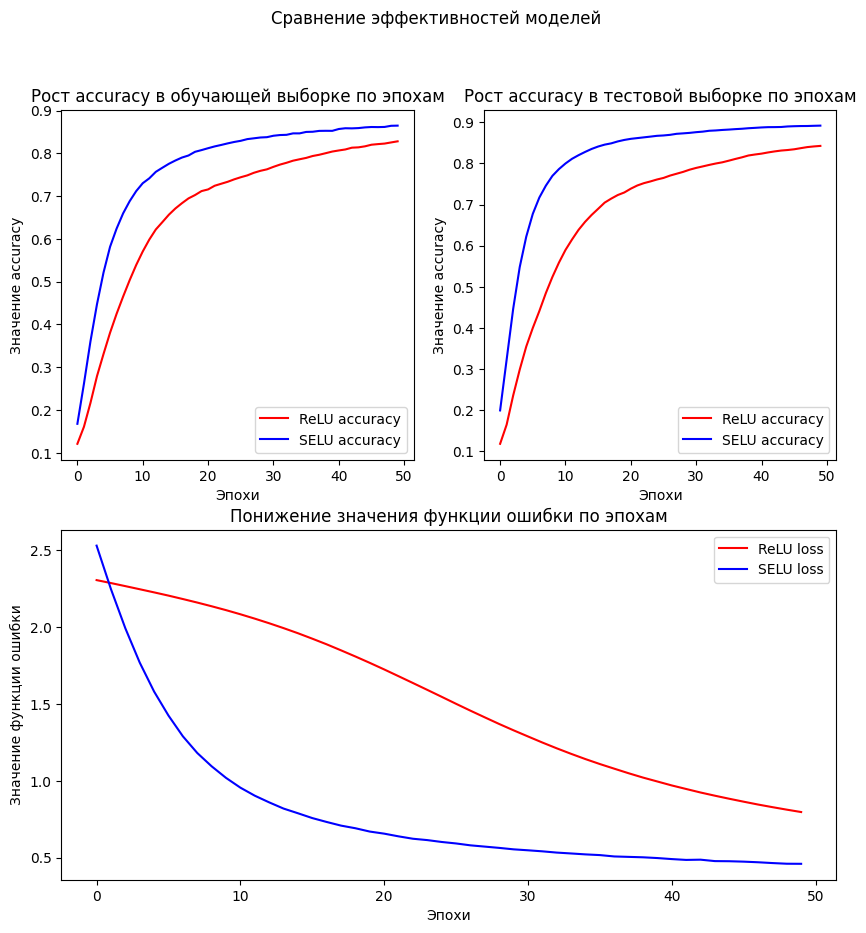

In [ ]:
# Вывод сравнительных диаграмм
diagrams(relu_data, selu_data)

## Модель

In [ ]:
class MLP(nn.Module):

    def __init__(self, in_features:int, out_features: int, drop_probability: float, self_norm: bool):
        super(MLP, self).__init__()

        # В зависимости от типа сети (обычная/самор-нормализующаяся) выбирается либо либо ReLU и обычный Dropout
        # либо SELU и AlphaDropout
        activation_layer = nn.SELU(True) if self_norm else nn.ReLU(True)
        dropout_layer = nn.AlphaDropout(p=drop_probability) if self_norm else nn.Dropout(p=drop_probability)

        # Сама сеть
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_features, out_features=1024),
            activation_layer,
            dropout_layer,
            nn.Linear(in_features=1024, out_features=512),
            activation_layer,
            dropout_layer,
            nn.Linear(in_features=512, out_features=256),
            activation_layer,
            dropout_layer,
            nn.Linear(in_features=256, out_features=128),
            activation_layer,
            dropout_layer,
            nn.Linear(in_features=128, out_features=out_features)
        )

        # Если сеть само-нормализующаяся, то надо переинициализировать веса с другим случайным распределением
        if self_norm:
            for parameter in self.model.parameters():
                # Если это смещение, то оно обнуляется 
                if len(parameter.shape) == 1:
                    nn.init.constant_(parameter, 0)
                # В обратном случае, это веса и их нужно переинициализировать
                else:
                    nn.init.kaiming_normal_(parameter, mode='fan_in', nonlinearity='linear')


    def forward(self, x):
        return self.model(x)

## Обучение (пример с неэффективной само-нормализующейся сетью)

In [ ]:
# Функция ошибки
loss = nn.CrossEntropyLoss
# Оптимизатор
optimizer = optim.Adam

In [ ]:
# Инициализация обычной сети и ее перевод на нужный процессор (обычный/графический)
mlp = MLP(
    in_features=dataloaders['train'].dataset.data.size(1) * dataloaders['train'].dataset.data.size(2),
    out_features=len(dataloaders['train'].dataset.classes),
    drop_probability=DROP_PROBABILITY,
    self_norm=False
).to(DEVICE)

In [ ]:
# Структура сети
print(mlp)

MLP(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=1024, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.05, inplace=False)
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): ReLU(inplace=True)
    (9): Dropout(p=0.05, inplace=False)
    (10): Linear(in_features=256, out_features=128, bias=True)
    (11): ReLU(inplace=True)
    (12): Dropout(p=0.05, inplace=False)
    (13): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
# Словарь для метрик по эпохам
relu_data = {'loss': [], 'train_accuracy': [], 'test_accuracy': []}
# Запуск
loop(
    mlp,
    dataloaders,
    optimizer(mlp.parameters(), lr=LR),
    loss(),
    relu_data
)

epoch = 1	time = 0.4913s
epoch = 2	time = 0.3791s
epoch = 3	time = 0.3894s
epoch = 4	time = 0.3778s
epoch = 5	time = 0.3573s
epoch = 6	time = 0.3566s
epoch = 7	time = 0.3777s
epoch = 8	time = 0.3508s
epoch = 9	time = 0.3513s
epoch = 10	time = 0.3564s
epoch = 11	time = 0.3599s
epoch = 12	time = 0.3653s
epoch = 13	time = 0.3657s
epoch = 14	time = 0.3528s
epoch = 15	time = 0.3645s
epoch = 16	time = 0.3465s
epoch = 17	time = 0.3683s
epoch = 18	time = 0.3680s
epoch = 19	time = 0.3566s
epoch = 20	time = 0.3560s
epoch = 21	time = 0.3582s
epoch = 22	time = 0.3607s
epoch = 23	time = 0.3525s
epoch = 24	time = 0.3583s
epoch = 25	time = 0.3516s
epoch = 26	time = 0.3494s
epoch = 27	time = 0.3691s
epoch = 28	time = 0.3548s
epoch = 29	time = 0.3569s
epoch = 30	time = 0.3497s
epoch = 31	time = 0.3541s
epoch = 32	time = 0.3943s
epoch = 33	time = 0.3859s
epoch = 34	time = 0.3757s
epoch = 35	time = 0.3866s
epoch = 36	time = 0.3765s
epoch = 37	time = 0.3859s
epoch = 38	time = 0.3883s
epoch = 39	time = 0.3

In [ ]:
# Инициализация само-нормализующейся сети и ее перевод на нужный процессор (обычный/графический)
mlp = MLP(
    in_features=dataloaders['train'].dataset.data.size(1) * dataloaders['train'].dataset.data.size(2),
    out_features=len(dataloaders['train'].dataset.classes),
    drop_probability=DROP_PROBABILITY,
    self_norm=True
).to(DEVICE)

In [ ]:
# Структура сети
print(mlp)

MLP(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=1024, bias=True)
    (2): SELU(inplace=True)
    (3): AlphaDropout(p=0.05, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): SELU(inplace=True)
    (6): AlphaDropout(p=0.05, inplace=False)
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): SELU(inplace=True)
    (9): AlphaDropout(p=0.05, inplace=False)
    (10): Linear(in_features=256, out_features=128, bias=True)
    (11): SELU(inplace=True)
    (12): AlphaDropout(p=0.05, inplace=False)
    (13): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
# Словарь для метрик по эпохам
selu_data = {'loss': [], 'train_accuracy': [], 'test_accuracy': []}
# Запуск
loop(
    mlp,
    dataloaders,
    optimizer(mlp.parameters(), lr=LR),
    loss(),
    selu_data
)

epoch = 1	time = 0.4070s
epoch = 2	time = 0.3921s
epoch = 3	time = 0.3921s
epoch = 4	time = 0.4037s
epoch = 5	time = 0.4021s
epoch = 6	time = 0.4085s
epoch = 7	time = 0.3928s
epoch = 8	time = 0.3875s
epoch = 9	time = 0.3951s
epoch = 10	time = 0.3957s
epoch = 11	time = 0.3973s
epoch = 12	time = 0.4055s
epoch = 13	time = 0.3944s
epoch = 14	time = 0.3939s
epoch = 15	time = 0.3974s
epoch = 16	time = 0.4051s
epoch = 17	time = 0.3991s
epoch = 18	time = 0.4298s
epoch = 19	time = 0.4342s
epoch = 20	time = 0.4659s
epoch = 21	time = 0.4276s
epoch = 22	time = 0.4416s
epoch = 23	time = 0.4393s
epoch = 24	time = 0.4345s
epoch = 25	time = 0.4371s
epoch = 26	time = 0.4513s
epoch = 27	time = 0.4037s
epoch = 28	time = 0.3903s
epoch = 29	time = 0.4049s
epoch = 30	time = 0.3950s
epoch = 31	time = 0.3854s
epoch = 32	time = 0.3902s
epoch = 33	time = 0.3923s
epoch = 34	time = 0.3977s
epoch = 35	time = 0.3934s
epoch = 36	time = 0.3960s
epoch = 37	time = 0.3917s
epoch = 38	time = 0.3959s
epoch = 39	time = 0.3

## Сравнение

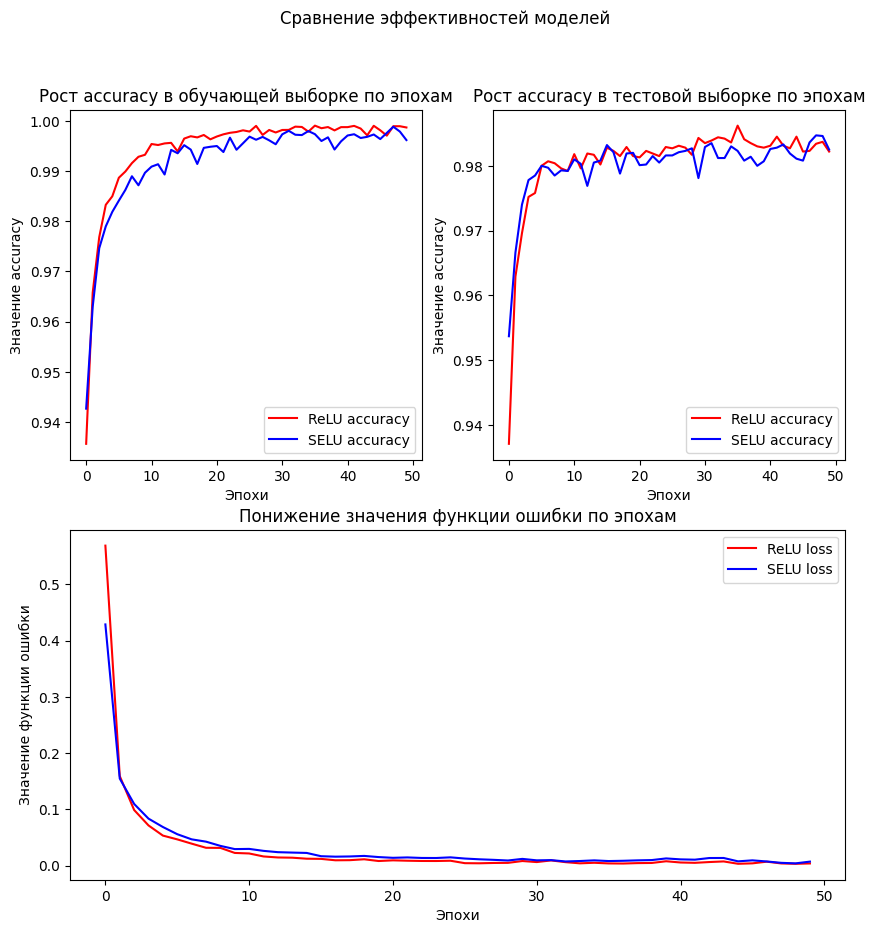

In [ ]:
# Вывод сравнительных диаграмм
diagrams(relu_data, selu_data)